# Tm9 Dorso-ventral labeling

Following scripts uses Tm9 dendritic arbor locations to label each neuron as dorsal or ventral.

In [ ]:
#@title Install and import required packages (imports)
# #install Libaries
#!pip install ipympl
#!pip install navis
#!pip3 install fafbseg



In [8]:
#@title import packages
from scipy.optimize import minimize
#import cv2
import numpy as np
import pandas as pd
import os
#from google.colab import files
import io
import math
import matplotlib.pyplot as plt
import navis
from fafbseg import flywire
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
#from google.colab import output
#output.enable_custom_widget_manager()

In [9]:
#@title Upload data
#uploaded = files.upload()
# human_data = pd.read_csv(io.BytesIO(uploaded['bahrami_100.csv']))
#data = pd.read_excel(io.BytesIO(uploaded['Tm9 proofreadings.xlsx']), header=0)

In [12]:
#Path and file
dataPath =  r'D:\Connectomics-Data\FlyWire\Excels\drive-data-sets'
fileDate = '20230701'
fileName = f'Tm9 proofreadings_{fileDate}.xlsx'
filePath = os.path.join(dataPath,fileName)
data = pd.read_excel(filePath)

First, use the neurons in the Left hemisphere

In [42]:
hemisphere = 'R'
coords = data[data['hemisphere']==hemisphere]['XYZ-ME'].to_numpy(dtype=str, copy=True)
xyz = np.zeros([np.shape(coords)[0],3])
for idx, coordinate in enumerate(coords):
  xyz[idx,:] = np.array([coordinate.split(',')],dtype=float)
xyz *=[4,4,40] # For plotting it using navis

Plot the current points on the medulla.

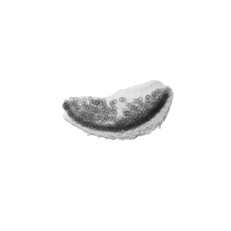

In [44]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(xyz[:,0],xyz[:,1],xyz[:,2],'.',color=[0,0,0,0.2])
OL_R = flywire.get_neuropil_volumes(['ME_L']) #['ME_R','LO_R','LOP_R']
navis.plot2d([OL_R], method='3d_complex', ax=ax,view=(172, 51),scalebar = '20 um')
ax.azim=-8
ax.elav=-43

Project the 3D points onto a 2D plane.

In [45]:
import numpy as np
from scipy.linalg import svd

# Assuming `points` is a Nx3 numpy array representing your points in 3D space
points = xyz
# 1. Fit a plane to the points
# Subtract mean
centroid = np.mean(points, axis=0)
points_centered = points - centroid

# Perform singular value decomposition
_, _, Vt = svd(points_centered)

# The normal to the plane is given by the last column of Vt
normal = Vt[-1, :]

# 2. Project the points onto the fitted plane
# Here, we project the original (centered) points onto the plane
projected_points = points_centered - np.dot(points_centered, normal)[:, None] * normal

# Add the centroid back to the projected points to get them in the original space
projected_points += centroid

Plot the original and projected points.

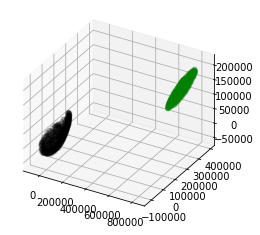

In [46]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(points_centered[:,0],points_centered[:,1],points_centered[:,2],color=[0,0,0,0.2])
ax.scatter(normal[0],normal[1],normal[2],color='r')
ax.scatter(projected_points[:,0],projected_points[:,1],projected_points[:,2],color=[0,0.5,0,0.2])


Center the data using the centroid.

(-100000.0, 100000.0)

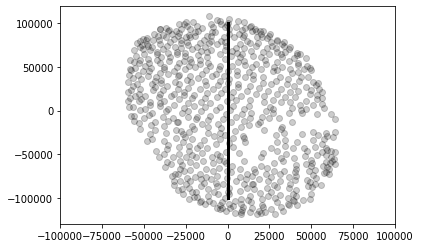

In [47]:
#centroid of the projected points
fig = plt.figure()
xy_ps = projected_points[:,:2]
centroid = projected_points.mean(axis=0)[:2]
shifted_p =  xy_ps- centroid
plt.scatter(shifted_p[:, 0], shifted_p[:, 1],color=[0,0,0,0.2])
lims = 100000
plt.plot([0,0],[-lims,lims],'k', linewidth=3)
plt.xlim([-lims,lims])
plt.xlim([-lims,lims])

Rotate 15 degrees to get an orthogonal axis to the dorso-ventral axis.

(-100000.0, 100000.0)

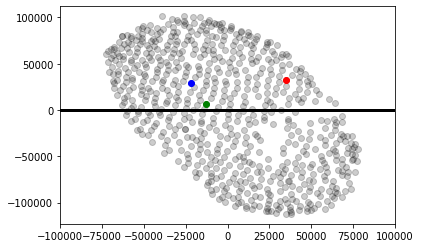

In [48]:
def rotate(origin, points, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    # px, py = point
    px = points[:,0]
    py = points[:,1]

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

fig = plt.figure()

# 15 degrees for 'L' hemisphere
# -15 degrees for 'R' hemisphere
rotated_p = rotate([0,0], shifted_p, math.radians(15))
rotated_p = np.array(rotated_p).T
plt.scatter(rotated_p[:, 0], rotated_p[:, 1],color=[0,0,0,0.2])
plt.scatter(rotated_p[100,0],rotated_p[100,1],color='r')
plt.scatter(rotated_p[105,0],rotated_p[105,1],color='b')
plt.scatter(rotated_p[200,0],rotated_p[200,1],color='g')
lims = 100000
plt.plot([-lims,lims],[0,0],'k', linewidth=3)
plt.xlim([-lims,lims])
plt.xlim([-lims,lims])

Label the neurons as dorsal or ventral

In [49]:
labels = np.zeros([rotated_p.shape[0],])
labels[rotated_p[:,1]>0] = 1
labels[rotated_p[:,1]<0] = 2

(-100000.0, 100000.0)

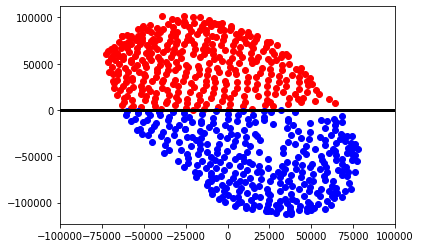

In [50]:
fig = plt.figure()
plt.scatter(rotated_p[labels==1,0],rotated_p[labels==1,1],color='r')
plt.scatter(rotated_p[labels==2,0],rotated_p[labels==2,1],color='b')

lims = 100000
plt.plot([-lims,lims],[0,0],'k', linewidth=3)
plt.xlim([-lims,lims])
plt.xlim([-lims,lims])

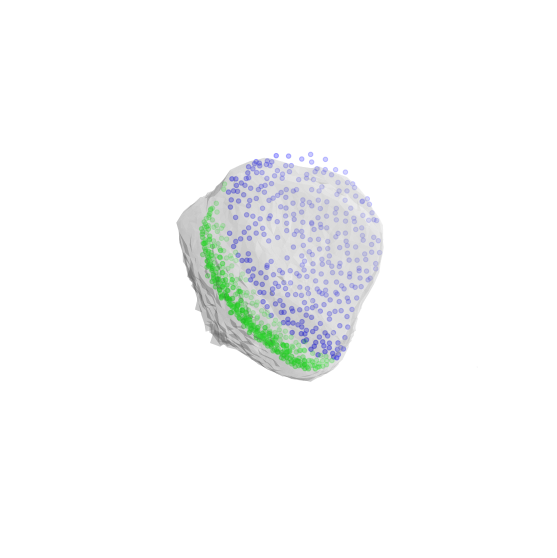

In [56]:
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(projection='3d')
ax.scatter(xyz[labels==1,0],xyz[labels==1,1],xyz[labels==1,2],'.',color=[0,1,0,0.5])
ax.scatter(xyz[labels==2,0],xyz[labels==2,1],xyz[labels==2,2],'.',color=[0,0,1,0.5])


# ax.scatter(centroid[0],centroid[1],centroid[2],color='r')



OL_R = flywire.get_neuropil_volumes(['ME_L']) #['ME_R','LO_R','LOP_R']
navis.plot2d([OL_R], method='3d_complex', ax=ax,view=(172, 51),scalebar = '20 um')
ax.azim=-600
ax.elav=-489

Add to the dataframe

In [30]:

# data['dorso-ventral'] = ''
data.loc[data['hemisphere']==hemisphere, 'dorso-ventral'] = labels

In [31]:
data.loc[data['dorso-ventral']==1.0, 'dorso-ventral'] = 'V'
data.loc[data['dorso-ventral']==2.0, 'dorso-ventral'] = 'D'

In [ ]:
from google.colab import files
data.to_csv('output.csv', encoding = 'utf-8-sig')
files.download('output.csv')

In [ ]:
# 3. Fit an ellipse to the projected points
# We'll use the general form of the equation of an ellipse,
# which is Ax^2 + Bxy + Cy^2 + Dx + Ey + F = 0

# First, create a matrix A that contains our variables
X = projected_points[:, 0]
Y = projected_points[:, 1]
A = np.column_stack((X**2, X*Y, Y**2, X, Y, np.ones_like(X)))

# Solve the normal equations A.T * A * a = A.T * b for a
_, _, _, a = np.linalg.lstsq(A, np.ones_like(X), rcond=None)

# The parameters of the ellipse are given by the elements of a
A, B, C, D, E, F = a

Check all the labels

In [ ]:
coords = data['XYZ-ME'].to_numpy(dtype=str, copy=True)
d_v = data['dorso-ventral']
xyz = np.zeros([np.shape(coords)[0],3])
for idx, coordinate in enumerate(coords):
  xyz[idx,:] = np.array([coordinate.split(',')],dtype=float)
xyz *=[4,4,40] # For plotting it using navis

Plot the current points on the medulla.

In [ ]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(xyz[d_v=='D',0],xyz[d_v=='D',1],xyz[d_v=='D',2],'.',color=[0,0,1,0.2])
ax.scatter(xyz[d_v=='V',0],xyz[d_v=='V',1],xyz[d_v=='V',2],'.',color=[0,1,0,0.2])

OL_R = flywire.get_neuropil_volumes(['ME_L']) #['ME_R','LO_R','LOP_R']
navis.plot2d([OL_R], method='3d_complex', ax=ax,view=(172, 51),scalebar = '20 um')
ax.azim=-600
ax.elav=-489

In [ ]:
a

In [32]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np

In [33]:
def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D = np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T, D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V = np.linalg.eig(np.dot(np.linalg.inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])

def ellipse_axis_length(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

def ellipse_angle_of_rotation2(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else:
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2


In [34]:
# def plot_ellipse(x, y):
#     a = fitEllipse(x, y)

#     center = ellipse_center(a)

#     phi = ellipse_angle_of_rotation2(a)

#     axes = ellipse_axis_length(a)

#     a, b = axes

#     ell = Ellipse(center, 2*a, 2*b, phi*180 / np.pi, facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.5))

#     ell_rotated = Ellipse(center, 2*a, 2*b, phi*180 / np.pi + 90, facecolor=(0,0,1,0.2), edgecolor=(0,0,0))
def plot_ellipse(x, y):
    a = fitEllipse(x, y)

    center = ellipse_center(a)

    phi = ellipse_angle_of_rotation2(a)

    axes = ellipse_axis_length(a)

    a, b = axes

    ell = Ellipse(center, 2*a, 2*b, phi*180 / np.pi, facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.5))

    ell_rotated = Ellipse(center, 2*a, 2*b, phi*180 / np.pi + 90, facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.5))

    fig, ax = plt.subplots()
    ax.add_patch(ell)
    ax.add_patch(ell_rotated)

    plt.scatter(x, y,color=[0,0,0,0.5])

    plt.show()

    return [ell, axes, center]

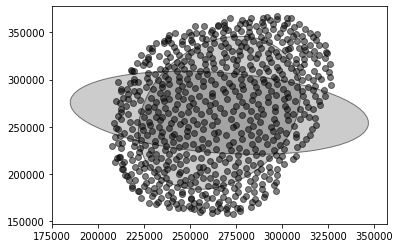

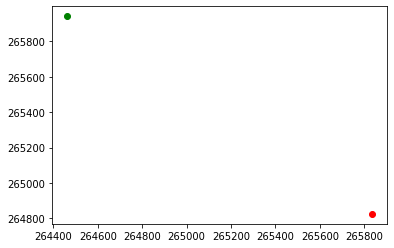

In [35]:
ellipse_m = plot_ellipse(projected_points[:, 0], projected_points[:, 1])
# plt.scatter(projected_points[100,0],projected_points[100,1],color='r')
# plt.scatter(projected_points[105,0],projected_points[105,1],color='b')
# plt.scatter(projected_points[200,0],projected_points[200,1],color='g')
plt.scatter(ellipse_m[2][0],ellipse_m[2][1],color='r', label='ellipse center')
plt.scatter(projected_points[:,0].mean(),projected_points[:,1].mean(),color='g', label='centroid')

(-100000.0, 100000.0)

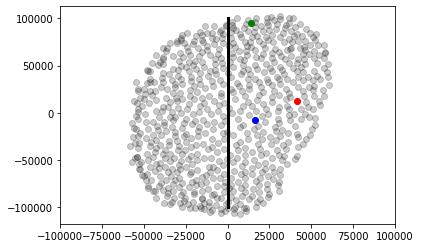

In [36]:
fig = plt.figure()
xy_ps = projected_points[:,:2]
shifted_p =  xy_ps- ellipse_m[2]
plt.scatter(shifted_p[:, 0], shifted_p[:, 1],color=[0,0,0,0.2])
plt.scatter(shifted_p[100,0],shifted_p[100,1],color='r')
plt.scatter(shifted_p[105,0],shifted_p[105,1],color='b')
plt.scatter(shifted_p[200,0],shifted_p[200,1],color='g')
lims = 100000
plt.plot([0,0],[-lims,lims],'k', linewidth=3)
plt.xlim([-lims,lims])
plt.xlim([-lims,lims])

(-100000.0, 100000.0)

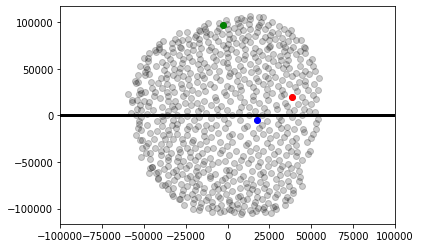

In [37]:
import math

def rotate(origin, points, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    # px, py = point
    px = points[:,0]
    py = points[:,1]

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

fig = plt.figure()

rotated_p = rotate([0,0], shifted_p, math.radians(10))
rotated_p = np.array(rotated_p).T
plt.scatter(rotated_p[:, 0], rotated_p[:, 1],color=[0,0,0,0.2])
plt.scatter(rotated_p[100,0],rotated_p[100,1],color='r')
plt.scatter(rotated_p[105,0],rotated_p[105,1],color='b')
plt.scatter(rotated_p[200,0],rotated_p[200,1],color='g')
lims = 100000
plt.plot([-lims,lims],[0,0],'k', linewidth=3)
plt.xlim([-lims,lims])
plt.xlim([-lims,lims])

In [38]:
np.array(rotated_p).shape

(685, 2)

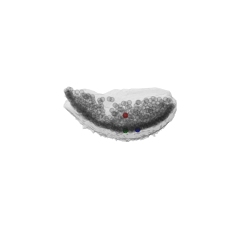

In [59]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(xyz[:,0],xyz[:,1],xyz[:,2],'.',color=[0,0,0,0.2])
ax.scatter(xyz[100,0],xyz[100,1],xyz[100,2],color='r')
ax.scatter(xyz[105,0],xyz[105,1],xyz[105,2],color='b')
ax.scatter(xyz[200,0],xyz[200,1],xyz[200,2],color='g')
# ax.scatter(centroid[0],centroid[1],centroid[2],color='r')



OL_R = flywire.get_neuropil_volumes(['ME_L']) #['ME_R','LO_R','LOP_R']
navis.plot2d([OL_R], method='3d_complex', ax=ax,scalebar = '20 um')
ax.azim=16
ax.elav=-50